# Apartment Rental Rate - Hamburg

This project analyzes rent prices in **Hamburg, Germany**. Data was collected in March, 2023 from [Immobilo](https://www.immobilo.de/mieten/wohnung/hamburg) using Selenium and BeautifulSoup. The average price and area of apartments will be analyzed. At the end, data from Hamburg is compared with Berlin in the notebook *Analysis Berlin*.

*Tools used in this project:*

- Python
- Numpy and Pandas for data cleaning
- Matplotlib and Seaborn for data visualization


# Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data = pd.read_excel('Apartment_Hamburg.xlsx')

In [2]:
# data.head()
# data.info()
# data.memory_usage(deep=True).sum()

# Data Preparation

In this part all data related to **apartment sharing/renting garage/ renting for students or senior citizens** will be removed because that isn't part of analysis. After that, we will clean up the columns *Room, Area* and *Price* by removing unnecessary words and leaving only digits for converting the columns into **integers/floats** for further calculation. Since there are only a few missing values in the columns *Rooms* and *Area*, we will drop them, but for the *Price* column we will replace the *'Preis auf Anfrage' (Price on request)* with **missing value**. 

Next, we will filter the data so that only values up to a maximum of **4 rooms** remain in the *Room* column.

For some apartments the cost of heating and additional costs (*Warmmiete*) are included in the rent, while in some prices it isn't (*Kaltmiete*). We will **adjust all prices** to the price with additional costs included. 
A *Nebenkosten* column was assigned in which the additional cost for heating was calculated. The area of an apartment was multiplied by **2.71** Euros. Information on the amount of additional costs for Hamburg can be found at this link: [Miet-Check](https://www.miet-check.de/mietnebenkosten/hamburg/)

In [3]:
def transformData(data):
    columns=['Title', 'Location', 'Rooms', 'Area', 'Price', 'Price_type',
       'Apartment_type']
    return (data
      [columns]
     .query('~Title.str.contains("garage|Studenten|WG|tausch|Senioren", case=False) & ~Apartment_type.str.contains("Wohngemeinschaft|Parken|Grundstück")')
     .dropna(subset=['Rooms', 'Area'], axis=0, thresh=2)
     .assign(Price = data.Price.replace('Preis auf Anfrage', np.nan)
             .astype(float),
             Rooms = data.Rooms.apply(lambda x: str(x).replace(',', '.'))
             .astype(float).apply(np.floor),
             Area = data.Area.apply(lambda x: str(x).replace(',', '.'))
             .astype(float).round(),
             Price_type = data.Price_type.fillna('Warmmiete') #assuming that missing values are Warmmiete
             )
    )
hamburg_df = transformData(data)

In [4]:
#hamburg_df.Apartment_type.value_counts()

hamburg_df.loc[hamburg_df.Apartment_type.str.contains('Haus'), 'Apartment_type'] = 'Haus'
hamburg_df.loc[hamburg_df.Apartment_type.str.contains('Wohnung'), 'Apartment_type'] = 'Wohnung'

In [5]:
hamburg_df = (hamburg_df
 .query('Rooms <= 4')
 .astype({'Rooms': 'int8', 'Area': 'int16', 'Price_type': 'category', 'Apartment_type': 'category'})
 .assign(Nebenkosten = (hamburg_df.Area*2.71).where(hamburg_df.Price_type == 'Kaltmiete, zzgl. NK')) #including the addiotional cost

)

In [6]:
def getPrice(hamburg_df):
    return (hamburg_df
 .assign(Price = hamburg_df[['Price', 'Nebenkosten']].sum(axis=1, min_count=1).round())
 .drop(['Price_type', 'Nebenkosten'], axis=1)
 .reset_index(drop=True)
)

hamburg = getPrice(hamburg_df)

In [7]:
# hamburg.info()
# hamburg.memory_usage(deep=True).sum()

# Removing Outliers

Outliers represent the **extreme values** of dataset. The describe method in Python will be used to define an **upper limit and lower limit**. All rows that belong to values below 25% of the data and rows that belong above 75% will be considered  as outliers and will be removed. For example, 25% for price (1 room) is *718.50€*, which means that any value below *718.50€* will be removed.

### Outliers Price

In [8]:
hamburg.groupby('Rooms').describe()

Area                                                          Price  \
       count        mean        std  min    25%    50%    75%    max  count   
Rooms                                                                         
1      469.0   36.929638  22.932951  1.0  25.00   35.0   43.0  150.0  467.0   
2      929.0   58.505920  21.371312  1.0  49.00   59.0   68.0  207.0  927.0   
3      664.0   80.628012  32.806603  1.0  69.00   80.0   94.0  346.0  664.0   
4      228.0  102.127193  42.580699  1.0  89.75  105.5  125.0  220.0  228.0   

                                                                             
              mean           std    min      25%     50%      75%       max  
Rooms                                                                        
1      1320.680942    754.802986   57.0   718.50  1181.0  1690.00    4992.0  
2      1504.830636    741.723366  171.0  1001.50  1421.0  1773.00    9360.0  
3      2608.549699  17429.355436  604.0  1387.25  1737.5  2264.75  450217.0  
4      2423.342105    905.427383  757.0  1900.00  2271.5  2756.25    8596.0

In [9]:
room1 = hamburg[hamburg.Rooms == 1]
room2 = hamburg[hamburg.Rooms == 2]
room3 = hamburg[hamburg.Rooms == 3]
room4 = hamburg[hamburg.Rooms == 4]

room1_price = room1.Price.between(718.50, 1690.00)
room2_price = room2.Price.between(1001.50, 1773.00)
room3_price = room3.Price.between(1387.25, 2264.75)
room4_price = room4.Price.between(1900.00, 2756.25)

price = [room1_price, room2_price, room3_price, room4_price]
price_series = pd.concat(price)

hamburg['Outliers_price'] = price_series

### Outliers Area

In [10]:
room1_area = room1.Area.between(25.0, 43.0)
room2_area = room2.Area.between(49.0, 68.0)
room3_area = room3.Area.between(69.00, 94.0)
room4_area = room4.Area.between(89.75, 125.0)

area = [room1_area, room2_area, room3_area, room4_area]
area_series = pd.concat(area)

hamburg['Outliers_area'] = area_series

In [11]:
hamburg = (hamburg
 .query('Outliers_price == True & Outliers_area == True', engine='python')
 .drop(['Outliers_price', 'Outliers_area'], axis=1)
 .assign(Price = hamburg.Price.fillna(hamburg.groupby('Rooms')['Price']
                                      .transform('mean')
                                      .round()))
)

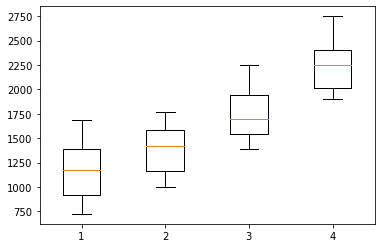

In [12]:
plot_rooms1 = hamburg[hamburg.Rooms == 1]
plot_rooms2 = hamburg[hamburg.Rooms == 2]
plot_rooms3 = hamburg[hamburg.Rooms == 3]
plot_rooms4 = hamburg[hamburg.Rooms == 4]

plt.boxplot([plot_rooms1['Price'], plot_rooms2['Price'], plot_rooms3['Price'], plot_rooms4['Price']]);

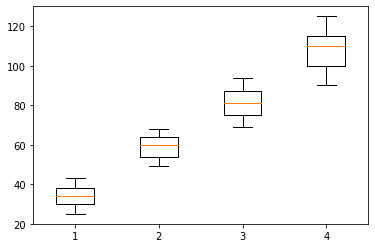

In [13]:
plt.boxplot([plot_rooms1['Area'], plot_rooms2['Area'], plot_rooms3['Area'], plot_rooms4['Area']]);

In [14]:
hamburg.groupby('Rooms').describe()

Area                                                            Price  \
       count        mean        std   min    25%    50%     75%    max  count   
Rooms                                                                           
1      120.0   33.925000   5.345480  25.0   30.0   34.0   38.25   43.0  120.0   
2      236.0   58.775424   5.910358  49.0   54.0   60.0   64.00   68.0  236.0   
3      173.0   80.982659   7.493000  69.0   75.0   81.0   87.00   94.0  173.0   
4       65.0  108.384615  10.071141  90.0  100.0  110.0  115.00  125.0   65.0   

                                                                         
              mean         std     min      25%     50%     75%     max  
Rooms                                                                    
1      1171.891667  289.506267   723.0   920.25  1173.5  1386.0  1690.0  
2      1387.025424  224.622064  1003.0  1166.50  1421.0  1588.5  1768.0  
3      1741.040462  242.613851  1388.0  1541.00  1700.0  1942.0  2250.0  
4      2263.492308  247.717337  1900.0  2018.00  2250.0  2400.0  2750.0

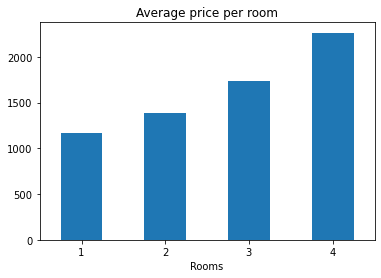

In [16]:
hamburg.groupby('Rooms')['Price'].mean().plot(kind='bar')
plt.title('Average price per room')
plt.xticks(rotation=0);

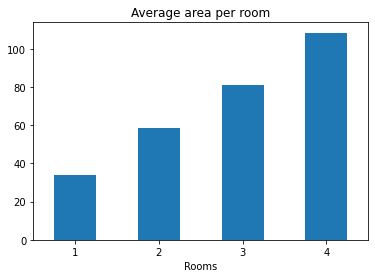

In [17]:
hamburg.groupby('Rooms')['Area'].mean().plot(kind='bar')
plt.title('Average area per room')
plt.xticks(rotation=0);

In [15]:
#hamburg.to_excel('HAMBURG.xlsx')